In [1]:
import warnings
warnings.filterwarnings('ignore')
# We import all our dependencies.
import numpy as np
import torch
import sys
sys.path.append('../../../')
from models.lvae import LadderVAE
from boilerplate import boilerplate
import lib.utils as utils
import training
from tifffile import imread
from matplotlib import pyplot as plt
from tqdm import tqdm
import wandb
import random
import tifffile as tiff
import glob

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [3]:
path="/group/jug/Sheida/maester_data/download/high_c1/contrastive/"
pathes = sorted(glob.glob(path+"train/mito_golgi_gra/*.tif"))
train_data = []
for path_one in pathes:
    train_data.append(tiff.imread(path_one))
pathes = sorted(glob.glob(path+"train/label_mito_golgi_gra/*.tif"))
train_label = []
for path_one in pathes:
    train_label.append(tiff.imread(path_one))
train_data = np.array(train_data)
train_label = np.array(train_label)
pathes = sorted(glob.glob(path+"validation/mito_golgi_gra/*.tif"))
val_data = []
for path_one in pathes:
    val_data.append(tiff.imread(path_one))
pathes = sorted(glob.glob(path+"validation/label_mito_golgi_gra/*.tif"))
val_label = []
for path_one in pathes:
    val_label.append(tiff.imread(path_one))
val_data = np.array(val_data)
val_label = np.array(val_label)
pathes = sorted(glob.glob(path+"test/mito_golgi_gra/*.tif"))
test_data = []
for path_one in pathes:
    test_data.append(tiff.imread(path_one))
pathes = sorted(glob.glob(path+"test/label_mito_golgi_gra/*.tif"))
test_label = []
for path_one in pathes:
    test_label.append(tiff.imread(path_one))
test_data = np.array(test_data)
test_label = np.array(test_label)    
# print("Shape of training images:", train_data.shape, "Shape of validation images:", val_data.shape, "Shape of test images:", test_data.shape)

In [4]:
### We extract overlapping patches of size ```patch_size x patch_size``` from training and validation images.
### Usually 64x64 patches work well for most microscopy datasets
patch_size = 64

In [5]:
num_patches = 1#int(float(699*760)/float(patch_size**2)*1)
train_images, train_y = utils.extract_patches(train_data, train_label, patch_size, num_patches)
val_images, val_y = utils.extract_patches(val_data, val_label, patch_size, num_patches)
test_images, test_y = utils.extract_patches(test_data, test_label, patch_size, num_patches)
# img_shape = (train_images.shape[1], train_images.shape[2])
# print("Shape of training images:", train_images.shape, "Shape of validation images:", val_images.shape)

100%|██████████| 37/37 [00:02<00:00, 15.83it/s]


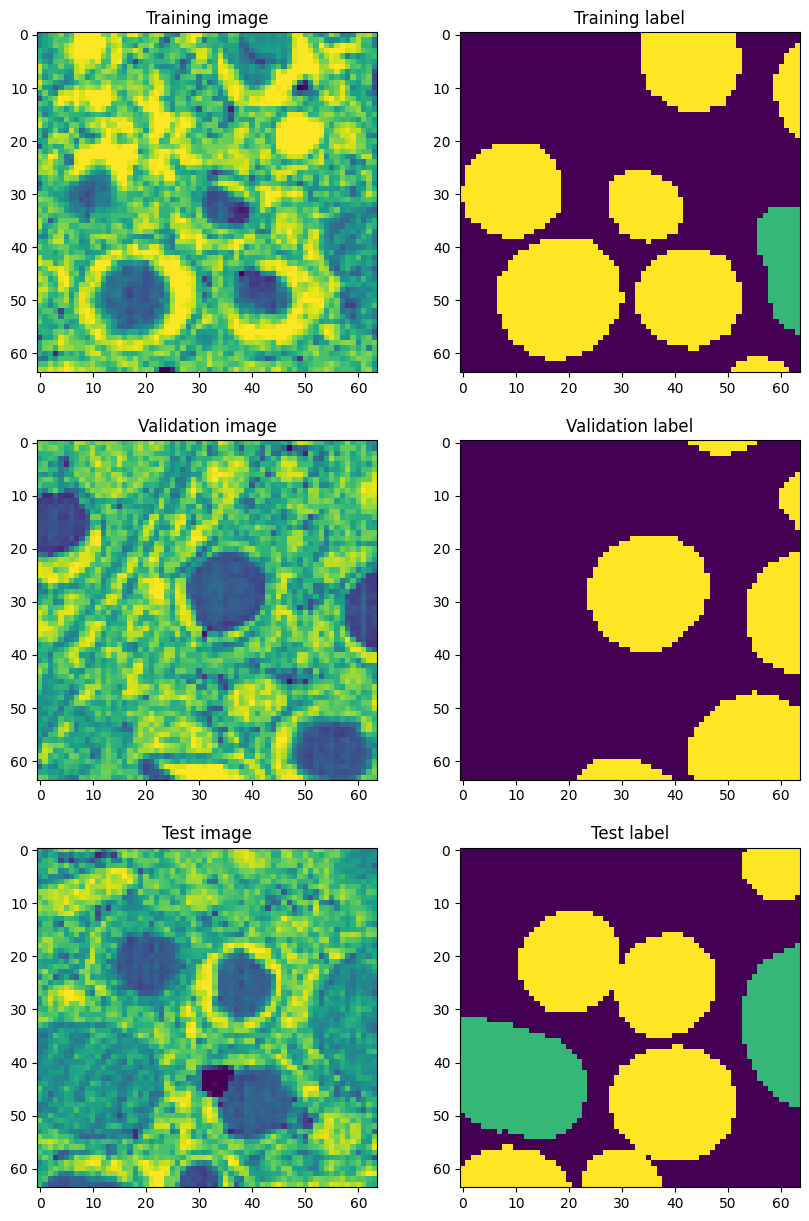

In [8]:
ind_train = np.random.randint(0, len(train_images))
ind_val = np.random.randint(0, len(val_images))
ind_test = np.random.randint(0, len(test_images))
plt.figure(figsize=(10,15))
plt.subplot(3, 2, 1)
plt.imshow(train_images[ind_train])
plt.title('Training image')
plt.subplot(3, 2, 2)
plt.imshow(train_y[ind_train])
plt.title('Training label')
plt.subplot(3, 2, 3)
plt.imshow(val_images[ind_val])
plt.title('Validation image')
plt.subplot(3, 2, 4)
plt.imshow(val_y[ind_val])
plt.title('Validation label')
plt.subplot(3, 2, 5)
plt.imshow(test_images[ind_test])
plt.title('Test image')
plt.subplot(3, 2, 6)
plt.imshow(test_y[ind_test])
plt.title('Test label')
plt.show()

In [7]:
break here

SyntaxError: invalid syntax (760050616.py, line 1)

In [ ]:
from skimage.measure import label, regionprops, regionprops_table
props = regionprops(train_label[0])

In [ ]:
for prop in props:
    print(prop['coords'])
    print(prop['label'])
    random_number = np.random.randint(len(prop['coords']))
    x = prop['coords'][random_number][0]
    y = prop['coords'][random_number][1]
    count = 0
    for i in range(x,x+4):
        for j in range(y,y+4):
            if [i,j] in prop['coords']:
                count += 1
    print(count)

In [ ]:
plt.imshow(train_images[1])
plt.show()
plt.close()
plt.imshow(train_y[1])

In [ ]:
model_name = "Contrastive_MAE"
directory_path = "./Trained_model/" 

# Data-specific
gaussian_noise_std = None
noiseModel = None 
# Training-specific
batch_size=128
virtual_batch = 64
lr=3e-4
max_epochs = 500
steps_per_epoch=400
test_batch_size=100

# Model-specific
num_latents = 5
z_dims = [32]*int(num_latents)
# z_dims = [32, 64, 128, 256, 512]
blocks_per_layer = 5
mask_size = 4
batchnorm = True
free_bits = 0.0 # if KLD is less than 1 then the loss won't be calculated
contrastive_learning = True

In [ ]:
debug             = True #[True, False]
save_output       = True #[True, False]
project           = 'Contrastive_MAE'


In [ ]:
train_loader, val_loader, test_loader, data_mean, data_std = boilerplate._make_datamanager(train_images,val_images,
                                                                                           test_images,batch_size,
                                                                                           test_batch_size)

model = LadderVAE(z_dims=z_dims,blocks_per_layer=blocks_per_layer,data_mean=data_mean,data_std=data_std,noiseModel=noiseModel,
                  device=device,batchnorm=batchnorm,free_bits=free_bits,img_shape=img_shape,contrastive_learning=contrastive_learning,mask_size=mask_size).cuda()

model.train() # Model set in training mode

In [ ]:
for batch in train_loader:
    break


In [ ]:
inp, tar = batch

In [ ]:
tar

In [ ]:
out = model(inp[:2,None].type(torch.float32).cuda())

In [ ]:
# print([x.shape for x in out['z']])
# out['z'][0].shape

In [ ]:
training.train_network(model=model,lr=lr,max_epochs=max_epochs,steps_per_epoch=steps_per_epoch,directory_path=directory_path,
                       train_loader=train_loader,val_loader=val_loader,test_loader=test_loader,
                       virtual_batch=virtual_batch,gaussian_noise_std=gaussian_noise_std,
                       model_name=model_name,val_loss_patience=30, debug=debug, save_output=save_output, project_name=project, batch_size=batch_size)

In [ ]:
break here

In [ ]:
trainHist=np.load(directory_path+"model/train_loss.npy")
reconHist=np.load(directory_path+"model/train_reco_loss.npy")
klHist=np.load(directory_path+"model/train_kl_loss.npy")
valHist=np.load(directory_path+"model/val_loss.npy")

In [ ]:
plt.figure(figsize=(18, 3))
plt.subplot(1,3,1)
plt.plot(trainHist,label='training')
plt.plot(valHist,label='validation')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(1,3,2)
plt.plot(reconHist,label='training')
plt.xlabel("epochs")
plt.ylabel("reconstruction loss")
plt.legend()

plt.subplot(1,3,3)
plt.plot(klHist,label='training')
plt.xlabel("epochs")
plt.ylabel("KL loss")
plt.legend()
plt.show()